In [79]:
import os
import json
import re
import scipy.io as spio
import numpy as np
from bokeh.plotting import figure
import tifffile as tf
import seaborn as sns
# %matplotlib notebook
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import skimage.color
from json_tricks.np import dump, dumps, load, loads
from mat2py import loadmat
from skimage import color
import cPickle as pkl
from  matplotlib.ticker import FuncFormatter
from matplotlib.ticker import MaxNLocator

def get_axis_limits(ax, scale=(0.9, 0.9)):
    return ax.get_xlim()[1]*scale[0], ax.get_ylim()[1]*scale[1]


def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)', text) ]
import os
import json
import re
import scipy.io as spio
import numpy as np
from bokeh.plotting import figure
import tifffile as tf
import seaborn as sns
# %matplotlib notebook
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import skimage.color
from json_tricks.np import dump, dumps, load, loads
from mat2py import loadmat
from skimage import color
import cPickle as pkl
from  matplotlib.ticker import FuncFormatter
from matplotlib.ticker import MaxNLocator

def get_axis_limits(ax, scale=(0.9, 0.9)):
    return ax.get_xlim()[1]*scale[0], ax.get_ylim()[1]*scale[1]


def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)', text) ]


In [96]:
analysis_id = 'analysis02'

source ='/nas/volume1/2photon/projects'
experiment = 'gratings_phaseMod' #'gratings_phaseMod' #'retino_bar' #'gratings_phaseMod'
session = '20171025_CE062' #'20170927_CE059' #'20170902_CE054' #'20170825_CE055'
acquisition = 'FOV1' #'FOV1_zoom3x' #'FOV1_zoom3x_run2' #'FOV1_planar'
functional_dir = 'functional' #'functional_subset'

iti_pre = 1.0 #float(options.iti_pre)

spacing = int(400) #int(options.gap)
curr_slice_idx = int(1) #int(options.sliceidx)




In [97]:
# ---------------------------------------------------------------------------------
# PLOTTING parameters:
# ---------------------------------------------------------------------------------
dont_use_raw = True #options.dont_use_raw

roi_interval = 1 #int(options.roi_interval)

avg_alpha = 1 #float(options.avg_alpha) # 1
avg_width = 1 #float(options.avg_width) #1.2
trial_alpha = 0.3 #float(options.trial_alpha) #0.8 #0.5 #0.5 #0.7
trial_width = 0.2 #float(options.trial_width) #0.2 #0.3

stim_offset = -0.5 #float(options.stimbar_offset) #-.75 #2.0
ylim_min = -3 #float(options.ymin) #-3
ylim_max = 3 #float(options.ymax) #50 #3 #100 #5.0 # 3.0

no_color = True #options.no_color
color_by_roi = True #options.color_by_roi

cmaptype = 'rainbow'


In [98]:

# ---------------------------------------------------------------------
# Get relevant stucts:
# ---------------------------------------------------------------------
acquisition_dir = os.path.join(source, experiment, session, acquisition)

# Create ROI dir in figures:
figbase = os.path.join(acquisition_dir, 'figures', analysis_id) #'example_figures'
if not os.path.exists(figbase):
    os.makedirs(figbase)

# Load reference info:
ref_json = 'reference_%s.json' % functional_dir 
with open(os.path.join(acquisition_dir, ref_json), 'r') as fr:
    ref = json.load(fr)
    
# Get ROIPARAMS:
roi_dir = os.path.join(ref['roi_dir'], ref['roi_id'][analysis_id]) #, 'ROIs')
roiparams = loadmat(os.path.join(roi_dir, 'roiparams.mat'))
if 'roiparams' in roiparams.keys():
    roiparams = roiparams['roiparams']
maskpaths = roiparams['maskpaths']
print maskpaths
if not isinstance(maskpaths, list) and len(maskpaths)==1:
    maskpaths = [maskpaths] #[str(i) for i in maskpaths]
if isinstance(maskpaths, unicode):
    maskpaths = [maskpaths]

nrois = roiparams['nrois']
if not isinstance(nrois, float):
    nrois = int(roiparams['nrois'][curr_slice_idx])
else:
    nrois = int(nrois)

/nas/volume1/2photon/projects/gratings_phaseMod/20171025_CE062/FOV1/ROIs/blobsDoG01/masks/20171025_CE062_FOV1_Slice01_Channel01_masks.mat


In [99]:
# Check slices to see if maskpaths exist for all slices, or just a subset:
if 'sourceslices' in roiparams.keys():
    slices = roiparams['sourceslices']
else:
    slices = np.arange(1, len(maskpaths)+1) #range(len(maskpaths))
print "Found masks for slices:", slices
if isinstance(slices, int):
    slices = [slices]
if not isinstance(slices, list): # i.e., only 1 slice
    slices = [int(i) for i in slices]
print "SLICES:", slices


# Get selected slice for current slice:
if isinstance(ref['slices'], int):
    all_slices = ['Slice%02d' % int(i+1) for i in range(ref['slices'])]
else:
    all_slices = ['Slice%02d' % int(i+1) for i in range(len(ref['slices']))]

curr_slice_idx = [i for i in sorted(slices)].index(curr_slice_idx)

slice_names = sorted(['Slice%02d' % int(i) for i in sorted(slices)], key=natural_keys)
print "SLICE NAMES:", slice_names
curr_slice_name = "Slice%02d" % slices[curr_slice_idx]


Found masks for slices: [1]
SLICES: [1]
SLICE NAMES: ['Slice01']


In [100]:


roi_interval = 1
tmprois = '' #options.rois_to_plot
if len(tmprois)==0:
    rois_to_plot = np.arange(0, nrois, roi_interval) #int(nrois/2)
    sort_name = '%s_all' % curr_slice_name #% roi_interval
else:
    rois_to_plot = tmprois.split(',')
    rois_to_plot = [int(r) for r in rois_to_plot]
    roi_string = "".join(['r%i' % int(r) for r in rois_to_plot])
    print roi_string
    sort_name = '%s_selected_%s' % (curr_slice_name, roi_string)

print "ROIS TO PLOT:", rois_to_plot


ROIS TO PLOT: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157]


In [101]:
if dont_use_raw is True:
    roi_trace_type = 'processed' #figdir = os.path.join(figbase, 'rois_processed')
else:
    roi_trace_type = 'raw'

if len(tmprois)==0:
    figdir = os.path.join(figbase, 'rois', 'all') #'rois')
else:
    figdir = os.path.join(figbase, 'rois', 'selected', sort_name)
if not os.path.exists(figdir):
    os.makedirs(figdir)
print "Saving ROI subplots to dir:", figdir


Saving ROI subplots to dir: /nas/volume1/2photon/projects/gratings_phaseMod/20171025_CE062/FOV1/figures/analysis02/rois/all


In [102]:

# Get PARADIGM INFO:
path_to_functional = os.path.join(acquisition_dir, functional_dir)
paradigm_dir = 'paradigm_files'
path_to_paradigm_files = os.path.join(path_to_functional, paradigm_dir)
#path_to_trace_structs = os.path.join(acquisition_dir, 'Traces', roi_method, 'Parsed')
path_to_trace_structs = os.path.join(acquisition_dir, 'Traces', ref['trace_id'][analysis_id], 'Parsed')
   

 
# Load stim trace structs:
print "Loading parsed traces..."
signal_channel = ref['signal_channel'][analysis_id] #int(options.selected_channel)

currchannel = "Channel%02d" % int(signal_channel)
currslice = "Slice%02d" % slices[curr_slice_idx] # curr_slice_idx
stimtrace_fns = os.listdir(path_to_trace_structs)
stimtrace_fn = "stimtraces_%s_%s.pkl" % (currslice, currchannel)
if not stimtrace_fn in stimtrace_fns:
    print "No stimtraces found for %s: %s, %s. Did you run files_to_trials.py?" % (analysis_id, currslice, currchannel)
else: 
    print "Selected Channel, Slice:", currchannel, currslice
    with open(os.path.join(path_to_trace_structs, stimtrace_fn), 'rb') as f:
	stimtraces = pkl.load(f)


stimlist = sorted(stimtraces.keys(), key=natural_keys)
nstimuli = len(stimlist)


Loading parsed traces...
Selected Channel, Slice: Channel01 Slice01


In [103]:
# Get stim names:
stiminfo = dict()
if experiment=='gratings_phaseMod' or experiment=='gratings_static':
    print "STIM | ori - sf"
    for stim in stimlist: #sorted(stimtraces.keys(), key=natural_keys):
	
        ori = stimtraces[stim]['name'].split('-')[2]
        sf = stimtraces[stim]['name'].split('-')[4]
        stiminfo[stim] = (int(ori), float(sf))
        print stim, ori, sf

    oris = sorted(list(set([stiminfo[stim][0] for stim in stimlist]))) #, key=natural_keys)
    sfs = sorted(list(set([stiminfo[stim][1] for stim in stimlist]))) #, key=natural_keys)
    noris = len(oris)
    nsfs = len(sfs)
else:
    for stim in sorted(stimlist, key=natural_keys):
        stiminfo[stim] = int(stim)

STIM | ori - sf
1 0 0.100000
2 30 0.100000
3 60 0.100000
4 90 0.100000
5 120 0.100000
6 150 0.100000


### EXTRACT DF info:

In [104]:

calcs = dict((roi, dict((stim, dict()) for stim in stimlist)) for roi in rois_to_plot)
dfstruct = dict((roi, dict((stim, dict()) for stim in stimlist)) for roi in rois_to_plot)

for roi in rois_to_plot:
    for stimnum,stim in enumerate(stimlist):

# 	# Output of files_to_trials.py
#         stimtraces[stim]['name'] = stimname
#         stimtraces[stim]['traces'] = np.asarray(curr_traces_allrois)
#         stimtraces[stim]['raw_traces'] = np.asarray(raw_traces_allrois)
#     	stimtraces[stim]['frames_stim_on'] = stim_on_frames 
#         stimtraces[stim]['frames'] = np.asarray(curr_frames_allrois)
#         stimtraces[stim]['ntrials'] = stim_ntrials[stim]
#         stimtraces[stim]['nrois'] = nrois
# 	stimtraces[stim]['volumerate'] = volumerate
# 	stimtraces[stim]['stim_dur'] = stim_on_sec
# 

        if dont_use_raw is True:
            currtraces = stimtraces[stim]['traces']
        else:
            currtraces = stimtraces[stim]['raw_traces']

	#print currtraces.shape
	if len(currtraces.shape)==1:
	    print "Incorrect number of frames provided across trials... Check files_to_trials.py"
        ntrialstmp = len(currtraces)
        nframestmp = [currtraces[i].shape[0] for i in range(len(currtraces))]
        diffs = np.diff(nframestmp)
        if sum(diffs)>0:
            print "Incorrect frame nums per trial:", stimnum, stim
            print nframestmp
	    	
        else:
            nframestmp = nframestmp[0]
 
#         raw = np.empty((ntrialstmp, nframestmp))
#         for trialnum in range(ntrialstmp):
# 	    print currtraces[trialnum].shape
#             raw[trialnum, :] = currtraces[trialnum][0:nframestmp, roi].T

	raw = currtraces[:,:,roi]
        #print raw.shape 
	ntrials = raw.shape[0]
        nframes_in_trial = raw.shape[1]

        xvals = np.empty((ntrials, nframes_in_trial))
        curr_dfs = np.empty((ntrials, nframes_in_trial))

        calcs[roi][stim] = dict()
        calcs[roi][stim]['zscores'] = []
        calcs[roi][stim]['mean_stim_on'] = []
        for trial in range(ntrials):
	    frame_on = stimtraces[stim]['frames_stim_on'][trial][0]
	    frame_on_idx = [i for i in stimtraces[stim]['frames'][trial]].index(frame_on)

# 	    if custom_mw is True:
#                 frame_on = stimtraces[stim]['frames_stim_on'][trial][0]
#                 frame_on_idx = [i for i in stimtraces[stim]['frames'][trial]].index(frame_on)
#             else:
#                 frame_on = stimtraces[stim]['frames_stim_on'][trial][0]
#                 frame_on_idx = [i for i in stimtraces[stim]['frames'][trial]].index(frame_on)
 
            xvals[trial, :] = (stimtraces[stim]['frames'][trial] - frame_on) #+ stimnum*spacing
            baseline = np.mean(raw[trial, 0:frame_on_idx])
	    if baseline==0:
                df = np.ones((1, nframes_in_trial))*np.nan
	    else:
                df = (raw[trial,:] - baseline) / baseline
                    #print stim, trial
            curr_dfs[trial,:] = df

            #stim_dur = stimtraces[stim]['frames_stim_on'] 
	    #stimtraces[stim]['frames_stim_on'][trial][1]-stimtraces[stim]['frames_stim_on'][trial][0]
	    volumerate = float(stimtraces[stim]['volumerate'])
	    nframes_on = int(round(stimtraces[stim]['stim_dur'] * volumerate))
            #print stimtraces[stim]['stim_dur'], nframes_on+frame_on_idx 
            baseline_frames = curr_dfs[trial, 0:frame_on_idx]
            stim_frames = curr_dfs[trial, frame_on_idx:frame_on_idx+nframes_on]
	    #print stim, len(stim_frames)
            std_baseline = np.nanstd(baseline_frames)
	    #print np.mean(stim_frames) 
            mean_stim_on = np.nanmean(stim_frames)
            zval_trace = mean_stim_on / std_baseline

            calcs[roi][stim]['zscores'].append(zval_trace)
            calcs[roi][stim]['mean_stim_on'].append(mean_stim_on)
            calcs[roi][stim]['name'] = stimtraces[stim]['name']

            dfstruct[roi][stim]['name'] = stimtraces[stim]['name']
            dfstruct[roi][stim]['tsec'] = np.true_divide(xvals[trial,:], volumerate)
	    dfstruct[roi][stim]['raw'] = raw
            dfstruct[roi][stim]['df'] = curr_dfs
            dfstruct[roi][stim]['frame_on'] = (frame_on_idx, frame_on)
            dfstruct[roi][stim]['baseline_vals'] = baseline_frames
            dfstruct[roi][stim]['stim_on_vals'] = stim_frames
            dfstruct[roi][stim]['stim_on_nframes'] = nframes_on 


/home/juliana/anaconda/envs/2pdev/lib/python2.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: Mean of empty slice
/home/juliana/anaconda/envs/2pdev/lib/python2.7/site-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in double_scalars
/home/juliana/anaconda/envs/2pdev/lib/python2.7/site-packages/ipykernel_launcher.py:85: RuntimeWarning: divide by zero encountered in double_scalars


### PLOTTING

In [105]:
# ---------------------------------------------------------------------------
# PLOTTING:
# ----------------------------------------------------------------------------

if no_color is True:
    colorvals = np.zeros((nrois, 3));
    #colorvals[:,1] = 1
else:
    colormap = plt.get_cmap(cmaptype)
    if color_by_roi:
	colorvals = colormap(np.linspace(0, 1, nrois)) #get_spaced_colors(nrois)
    else:
	colorvals = colormap(np.linspace(0, 1, nstimuli)) #get_spaced_colors(nstimuli)

In [106]:
# Set up subplots:
if experiment=='gratings_phaseMod' or experiment=='gratings_static':
    nrows = nsfs
    ncols = noris
else:
    nrows = 5 #int(np.ceil(np.sqrt(len(stimlist))))
    ncols = int(len(stimlist))/nrows #int(np.ceil(len(stimlist)/float(nrows)))

print nrows, ncols


1 6


In [107]:
stimnames = [str(int(i)) for i in stimlist]
stimnums = [int(i) for i in stimlist]

# get the tick label font size
fontsize_pt = 20 #float(plt.rcParams['ytick.labelsize'])
dpi = 72.27
spacer = 20

# comput the matrix height in points and inches
matrix_height_pt = fontsize_pt * nrows * spacer
matrix_height_in = matrix_height_pt / dpi

# compute the required figure height 
top_margin = 0.01  # in percentage of the figure height
bottom_margin = 0.05 # in percentage of the figure height
figure_height = matrix_height_in / (1 - top_margin - bottom_margin)

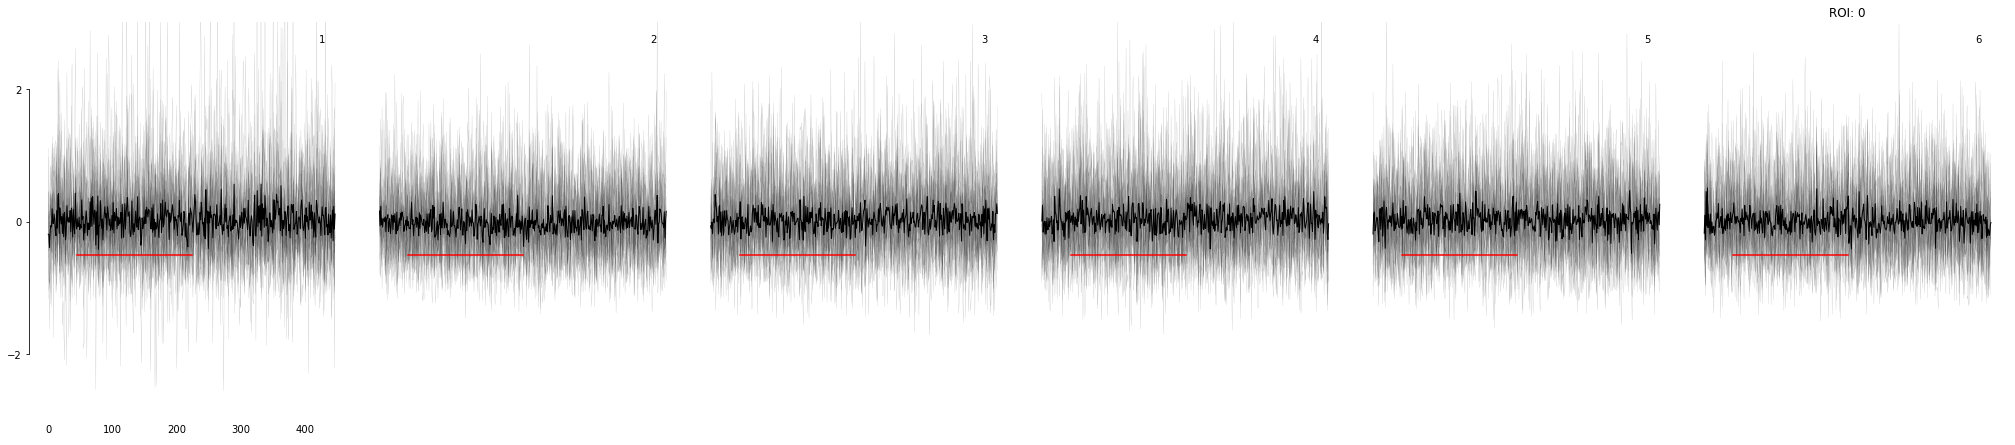

In [109]:
# for roi in rois_to_plot:
for roi in [0]:
    # build the figure instance with the desired height
    fig, axs = plt.subplots(
	    nrows=nrows, 
	    ncols=ncols, 
	    sharex=True,
	    sharey=True,
	    figsize=(figure_height*ncols,figure_height), 
	    gridspec_kw=dict(top=1-top_margin, bottom=bottom_margin, wspace=0.05, hspace=0.05))

    row=0
    col=0
    #print nrows, ncols
    plotidx = 0
    for stim in sorted(stimlist, key=natural_keys): #ROIs:

	if col==(ncols) and nrows>1:
	    row += 1
	    col = 0

	if len(axs.shape)>1:
	    ax_curr = axs[row, col] #, col]
	else:
	    ax_curr = axs[col]
	
	
	curr_dfs = dfstruct[roi][stim]['df']
	ntrials = curr_dfs.shape[0]
	ntrialframes = curr_dfs.shape[1]
	tsec = np.arange(0, ntrialframes)

	for trial in range(ntrials):
	    if color_by_roi:
		ax_curr.plot(tsec, curr_dfs[trial,:], color=colorvals[roi], alpha=trial_alpha, linewidth=trial_width)
	    else:
		ax_curr.plot(tsec, curr_dfs[trial,:], color=colorvals[stimnum], alpha=trial_alpha, linewidth=trial_width)

	# Plot average:
	avg = np.nanmean(curr_dfs, axis=0) 
	if color_by_roi:
	    ax_curr.plot(tsec, avg, color=colorvals[roi], alpha=avg_alpha, linewidth=avg_width)
	else:
	    ax_curr.plot(tsec, avg, color=colorvals[stimnum], alpha=avg_alpha, linewidth=avg_width)

	# Plot stimulus ON period:
	frame_on_idx = dfstruct[roi][stim]['frame_on'][0]
	#print frame_on_idx
	stim_frames = [frame_on_idx, frame_on_idx+dfstruct[roi][stim]['stim_on_nframes']]

	if no_color is True:
            ax_curr.plot(stim_frames, np.ones((2,))*stim_offset, color='r')
	else:
	    ax_curr.plot(stim_frames, np.ones((2,))*stim_offset, color='k')


	# Deal with axes:  
	ax_curr.set_ylim([ylim_min, ylim_max])

	if col==0:
	    ax_curr.set_xlabel('')
	    ax_curr.tick_params(axis='x', which='both',length=0)
	    ax_curr.yaxis.set_major_locator(MaxNLocator(5, integer=True))
	    #ax_curr.xaxis.set_major_locator(MaxNLocator(noris, integer=True))
	    sns.despine(bottom=True, right=True, offset=5, trim=True, ax=ax_curr)
	else:
	    ax_curr.axis('off')

	ax_curr.annotate(str(stim), xy=get_axis_limits(ax_curr))
	#ax_curr.legend().set_visible(False)

	col = col + 1
	    
	#ptitle = "%2.0f., %0.2f" % (float(stiminfo[stim][0]), float(stiminfo[stim][1]))
	
	plotidx += 1

    nleftover = (nrows*ncols)-plotidx
    for p in range(nleftover):
	ax_curr = axs[row, col+p]
	ax_curr.axis('off')


    #plt.subplots_adjust(top=1)
    plt.title('ROI: %i' % int(roi))

    #figname = '%s_stimgrid_roi%i_%s.png' % (currslice, int(roi), roi_trace_type)
    #plt.savefig(os.path.join(figdir, figname), bbox_inches='tight', pad=0)

    plt.show()

    #plt.close(fig)
